In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import warnings
import random

warnings.filterwarnings("ignore")

In [4]:
demand_data = pd.read_csv('data/Daily_Demand_Forecasting_Orders.csv', delimiter=';')

In [5]:
demand_data.head()

,"Week_of_the_month_(first_week,second,third,fourth_or_fifth_week)",Day_of_the_week_(Monday_to_Friday),Non-urgent_order,Urgent_order,Order_type_A,Order_type_B,Order_type_C,Fiscal_sector_orders,Orders_from_the_traffic_controller_sector,Banking_orders_(1),Banking_orders_(2),Banking_orders_(3),Target_(Total_orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


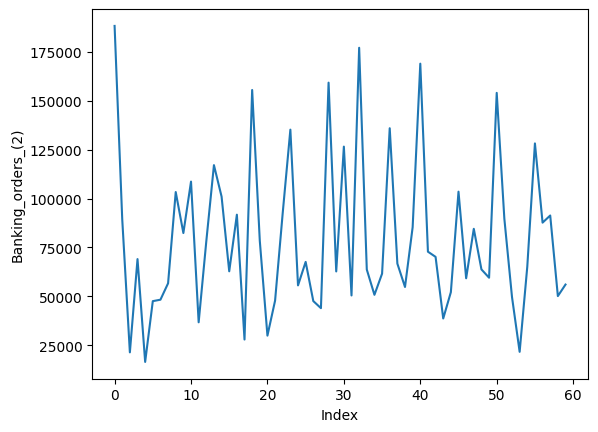

In [6]:
ax = sn.lineplot(demand_data, y='Banking_orders_(2)', x=demand_data.index)
ax.set_xlabel('Index');

Using the autoregressive model AR($p$):

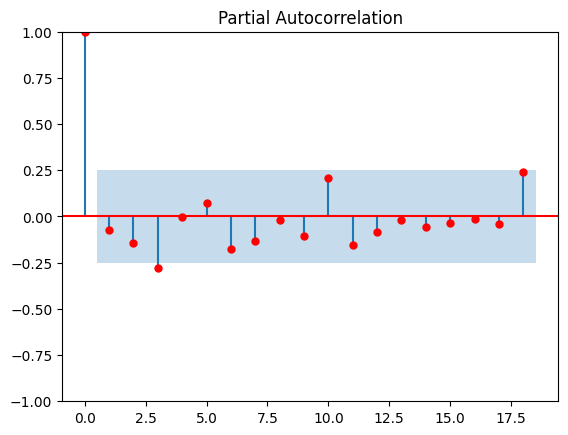

In [7]:
plot_pacf(x=demand_data['Banking_orders_(2)'], color='r');

### $AR(p)$ model

The third lag goes outside the 95% C.L. region, then we expect the model to be of order 3, or $p=3$.

Let us see if an automated package (`pmdarima`) finds the same order:

In [8]:
# Fit ARIMA model and automatically select the best ARIMA model using AIC
model = auto_arima(demand_data['Banking_orders_(2)'], start_p=1, start_q=0,
                   max_p=10, max_q=0, seasonal=False, trace=True, information_criterion='aic')

# Get the order of the best-fitted ARIMA model
order = model.get_params()['order']
print("Optimal ARIMA order:", order)

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1485.319, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1539.816, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1477.133, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1477.314, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1448.834, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1448.449, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1446.364, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.301 seconds
Optimal ARIMA order: (0, 0, 0)


It had a different result, with order zero ($p=0$).

We need to crosscheck it using the **ARIMA** class and **AutoReg** from `statsmodels`:

Lags AutoReg: 1 Lags ARIMA: 17


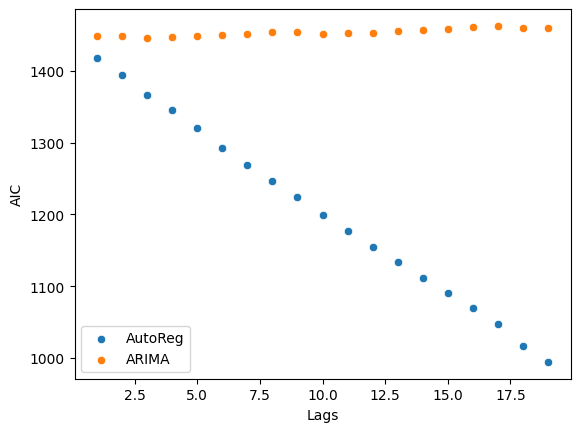

In [9]:
aic_AR_list, aic_ARIMA_list = [],[]

for lag in range(1,20):
    model = AutoReg(demand_data['Banking_orders_(2)'], lags=lag).fit()
    aic_AR_list.append(model.aic)

    model = ARIMA(demand_data['Banking_orders_(2)'], order=(lag,0,0)).fit()
    aic_ARIMA_list.append(model.aic)

sn.scatterplot(x=list(range(1,20)), y=aic_AR_list, label='AutoReg')
sn.scatterplot(x=list(range(1,20)), y=aic_ARIMA_list, label='ARIMA')
plt.legend()
plt.xlabel('Lags')
plt.ylabel('AIC')
print('Lags AutoReg:', aic_AR_list.index(max(aic_AR_list))+1, 'Lags ARIMA:', aic_ARIMA_list.index(max(aic_ARIMA_list))+1)
plt.show()

While `AutoReg` provided 1 as the optmized number of lags, `ARIMA` outputed it as 17.

We will trust on the visual autoregression plot:

In [10]:
model_ar = ARIMA(demand_data['Banking_orders_(2)'], order=(3,0,0)).fit()
model_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Banking_orders_(2)   No. Observations:                   60
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -717.601
Date:                Thu, 29 Feb 2024   AIC                           1445.202
Time:                        13:01:20   BIC                           1455.674
Sample:                             0   HQIC                          1449.298
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.94e+04   3631.436     21.865      0.000    7.23e+04    8.65e+04
ar.L1         -0.1353      0.181     -0.746      0.456      -0.491       0.220
ar.L2         -0.2016      0.111     -1.810      0.070      -0.420       0.017
ar.L3         -0.3191      0.157     -2.033      0.042      -0.627      -0.011
sigma2       1.27e+09      0.022   5.65e+10      0.000    1.27e+09    1.27e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.12
Prob(Q):                              0.97   Prob(JB):                         0.08
Heteroskedasticity (H):               0.52   Skew:                             0.69
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.43e+28. Standard errors may be unstable.
"""

The same model as above but with a more general class (`SARIMAX`), with the possibility of fixing the hyperparameters:

In [11]:
model = SARIMAX(demand_data['Banking_orders_(2)'], order=(3,0,0))

# If we want to fix some parameters
with model.fix_params({'ar.L1':0, 'ar.L2':.32, 'ar.L3':.20}):
    fit = model.fit(disp=False)

# fit = model.fit(disp=False)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Banking_orders_(2)   No. Observations:                   60
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -746.944
Date:                Thu, 29 Feb 2024   AIC                           1495.889
Time:                        13:01:20   BIC                           1497.983
Sample:                             0   HQIC                          1496.708
                                 - 60                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1 (fixed)          0        nan        nan        nan         nan         nan
ar.L2 (fixed)     0.3200        nan        nan        nan         nan         nan
ar.L3 (fixed)     0.2000        nan        nan        nan         nan         nan
sigma2         3.044e+09   4.05e+08      7.518      0.000    2.25e+09    3.84e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 4.99
Prob(Q):                              0.58   Prob(JB):                         0.08
Heteroskedasticity (H):               0.83   Skew:                             0.71
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The aucorrelation of resulting residuals:

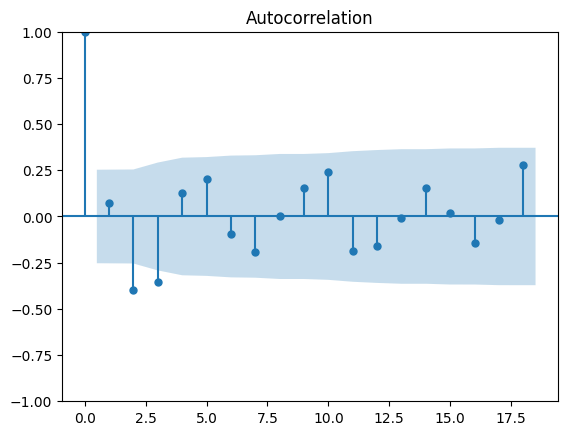

In [12]:
plot_acf(fit.resid);

We apply the **Ljung-Box** test to check if the series is simply random or follow some serial autocorrelation, where:

- H0: The data does not exhibit serial correlation

- H1: The data does exhibit serial correlation

In [13]:
acorr_ljungbox(fit.resid, lags=[10], model_df=3, return_df=True)

,lb_stat,lb_pvalue
10,31.854311,0.000043


We can reject the null hypothesis H0.

Let us look at predictions from the fitted model:

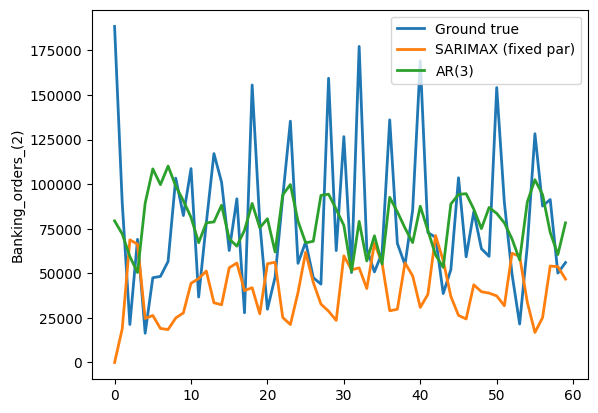

In [14]:
sn.lineplot(demand_data['Banking_orders_(2)'], lw=2, label='Ground true')
sn.lineplot(fit.fittedvalues, lw=2, label='SARIMAX (fixed par)');
sn.lineplot(model_ar.fittedvalues, lw=2, linestyle='-', label='AR(3)');

We can check if the variation of predictions is correlated to ground true:

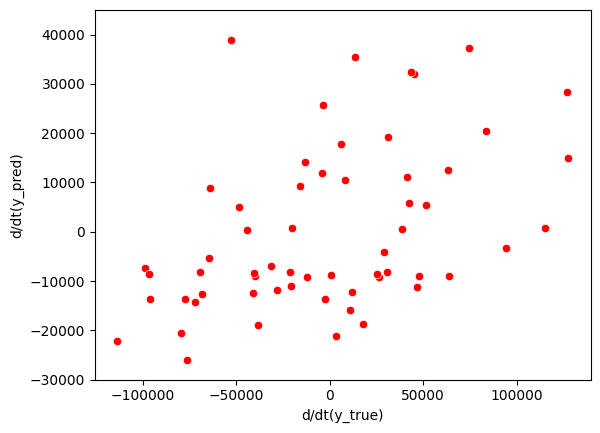

In [15]:
y_true = demand_data['Banking_orders_(2)']
y_pred = model_ar.fittedvalues

sn.scatterplot(x=np.diff(y_true), y=np.diff(y_pred), c='r')
plt.xlabel('d/dt(y_true)')
plt.ylabel('d/dt(y_pred)')
plt.ylim(-30000, 45000);

We can predict steps further the actual data:

In [16]:
model_ar = ARIMA(demand_data['Banking_orders_(2)'], order=(3,0,0)).fit()
steps_further = 3
y_pred_3 = model_ar.forecast(steps=steps_further)

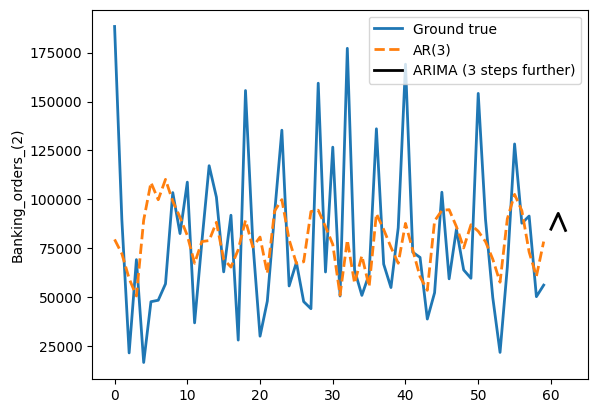

In [17]:
sn.lineplot(demand_data['Banking_orders_(2)'], lw=2, label='Ground true')
sn.lineplot(model_ar.fittedvalues, lw=2, linestyle='--', label='AR(3)');
sn.lineplot(y_pred_3, c='k', lw=2, linestyle='-', label='ARIMA (3 steps further)');

The variance decreases when we predict further in the future (meaning that we have less and less information and predictability going further):

In [18]:
for i in [3,5,10,20,30,40,50]:
    y_pred = model_ar.forecast(steps=i)
    print('Variance/10^5 (%i steps): %.1f'%(i, np.var(y_pred)/1e5))

Variance/10^5 (3 steps): 158.5
Variance/10^5 (5 steps): 469.4
Variance/10^5 (10 steps): 255.9
Variance/10^5 (20 steps): 134.1
Variance/10^5 (30 steps): 90.8
Variance/10^5 (40 steps): 68.7
Variance/10^5 (50 steps): 55.2


### $AR(p)$ $MA(q)$ model

To define $q$ for $MA$ models, we use ACF:

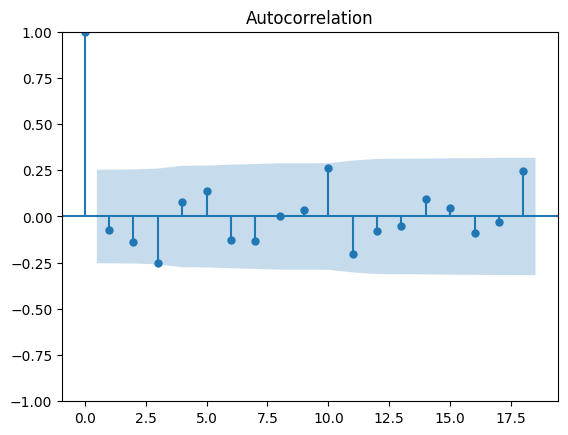

In [19]:
plot_acf(demand_data['Banking_orders_(2)']);

In [20]:
model_ma = ARIMA(demand_data['Banking_orders_(2)'], order=(0,0,9))
fit_ma = model_ma.fit()

In [21]:
acorr_ljungbox(fit_ma.resid, lags=[20], model_df=9, return_df=True)

,lb_stat,lb_pvalue
20,12.284753,0.342624


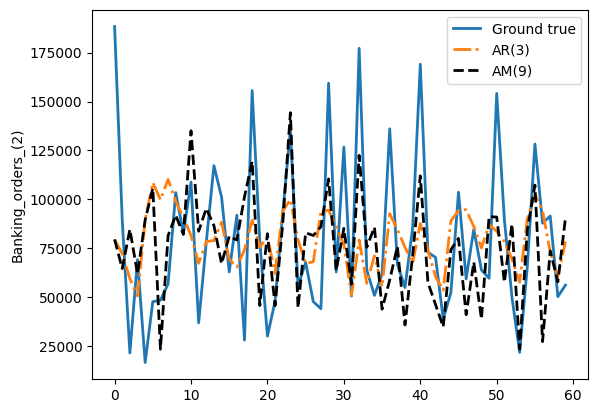

In [22]:
sn.lineplot(demand_data['Banking_orders_(2)'], lw=2, label='Ground true')
sn.lineplot(model_ar.fittedvalues, lw=2, linestyle='-.', label='AR(3)')
sn.lineplot(fit_ma.fittedvalues, lw=2, linestyle='--', label='AM(9)', c='k');

### $ARIMA(p,d,q)$ model

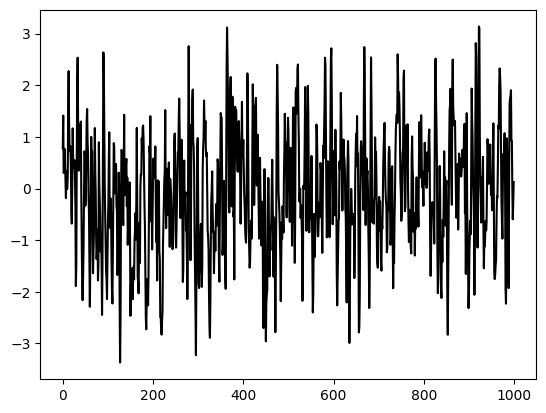

In [32]:
random.seed(123)

i_ar = np.random.randint(1,5,1)[0]
i_ma = np.random.randint(1,5,1)[0]
ar_params = np.random.uniform(-0.99, 0.99, i_ar)
ma_params = np.random.uniform(0, 0.99, i_ma)

# Generate ARMA process
arma_process = sm.tsa.ArmaProcess(ar_params, ma_params)
# Generate a sample
y = arma_process.generate_sample(nsample=1000)
# True order
order_true = (i_ar, 0, i_ma)

sn.lineplot(y, c='k');

**Determining the order of the model by hand:**

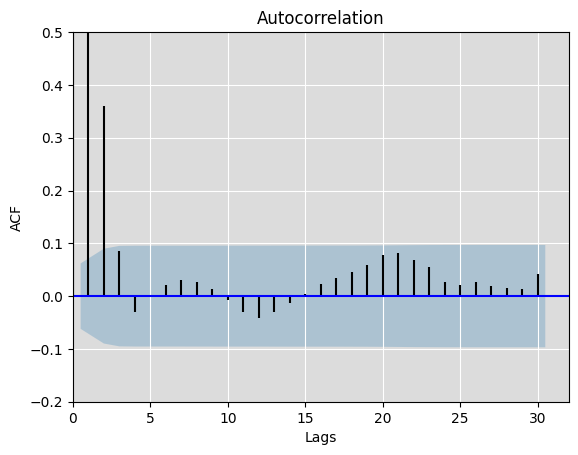

In [33]:
fig, ax = plt.subplots()
ax.set_facecolor('gainsboro')
plot_acf(y, marker=None, color='b', vlines_kwargs={'color':'k'}, ax=ax)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.xlim(0,)
plt.ylim(-0.2,.5)
plt.grid(c='w')
plt.show()

The ACF suggests $q = 2$.

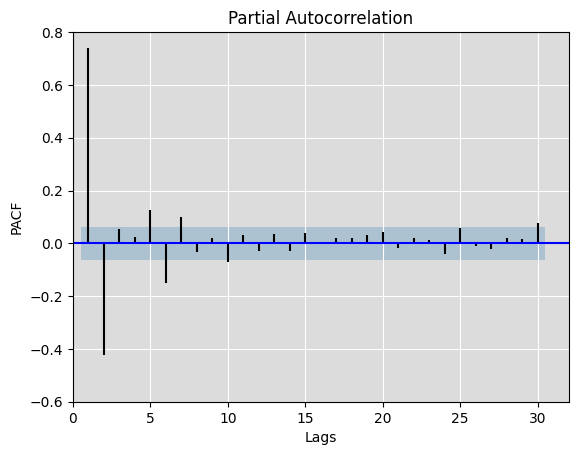

In [38]:
fig, ax = plt.subplots()
ax.set_facecolor('gainsboro')
plot_pacf(y, marker=None, color='b', vlines_kwargs={'color':'k'}, ax=ax)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.xlim(0,)
plt.ylim(-0.6,.8)
plt.grid(c='w')
plt.show()

PACF suggests $p=1$ and 2 (we have the information that $p < 6$). We choose $p=2$.

In [39]:
order_visual = (2,0,2)

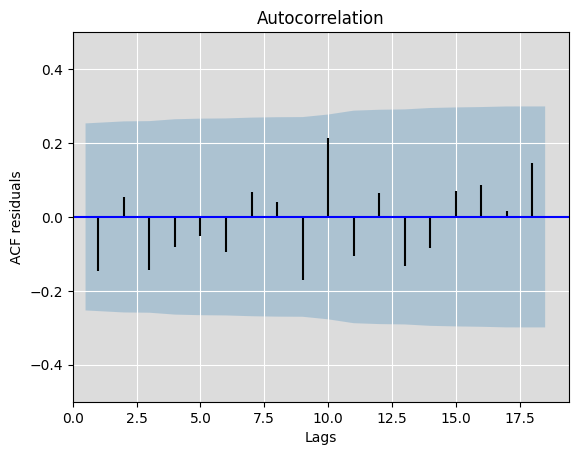

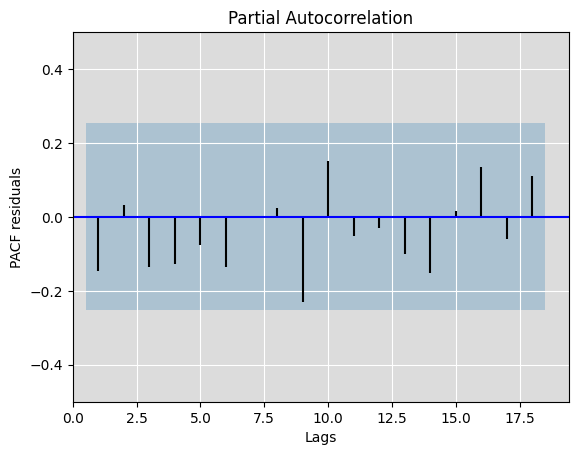

In [40]:
model_arma = ARIMA(demand_data['Banking_orders_(2)'], order=order_visual)
fit_arma = model_arma.fit()

fig, ax = plt.subplots()
ax.set_facecolor('gainsboro')
plot_acf(fit_arma.resid, marker=None, color='b', vlines_kwargs={'color':'k'}, ax=ax)
plt.xlabel('Lags')
plt.ylabel('ACF residuals')
plt.xlim(0,)
plt.ylim(-0.5,.5)
plt.grid(c='w')
plt.show()

fig, ax = plt.subplots()
ax.set_facecolor('gainsboro')
plot_pacf(fit_arma.resid, marker=None, color='b', vlines_kwargs={'color':'k'}, ax=ax)
plt.xlabel('Lags')
plt.ylabel('PACF residuals')
plt.xlim(0,)
plt.ylim(-0.5,.5)
plt.grid(c='w')
plt.show()

The residuals are white noise, then we determined the order to be: $(2,0,2)$

See a [book's algorithm](https://otexts.com/fpp2/arima-r.html) and also a [set of rules](https://people.duke.edu/~rnau/arimrule.htm) for details.

We will plot correlation coefficients for plotted values to investigate:

In [41]:
for i in range(1,6):
    for j in range(1,6):
        model_arma = ARIMA(y, order=(i,0,j))
        fit_arma = model_arma.fit()
        correlation = np.corrcoef(y, fit_arma.fittedvalues)[0,1]
        print('Correlation:', correlation, 'Order:', (i,0,j))

Correlation: 0.7901683683719045 Order: (1, 0, 1)
Correlation: 0.7907741396646505 Order: (1, 0, 2)
Correlation: 0.8074537669332399 Order: (1, 0, 3)
Correlation: 0.8075466100553664 Order: (1, 0, 4)
Correlation: 0.8075503834619573 Order: (1, 0, 5)
Correlation: 0.7940363871578583 Order: (2, 0, 1)
Correlation: 0.7940456681951223 Order: (2, 0, 2)
Correlation: 0.8075065082452019 Order: (2, 0, 3)
Correlation: 0.8075514653934613 Order: (2, 0, 4)
Correlation: 0.8086355225012998 Order: (2, 0, 5)
Correlation: 0.8015115932519491 Order: (3, 0, 1)
Correlation: 0.8016690325138712 Order: (3, 0, 2)
Correlation: 0.8076043499795509 Order: (3, 0, 3)
Correlation: 0.8076071042760787 Order: (3, 0, 4)
Correlation: 0.8078468512849968 Order: (3, 0, 5)
Correlation: 0.8018342925040026 Order: (4, 0, 1)
Correlation: 0.8018438689193819 Order: (4, 0, 2)
Correlation: 0.8009109633697324 Order: (4, 0, 3)
Correlation: 0.807645603503636 Order: (4, 0, 4)
Correlation: 0.8076824192115296 Order: (4, 0, 5)
Correlation: 0.806637

In [42]:
print('Estimated orders')
print('By the ACF and PACF plots:', order_visual)
print('By the correlation coefficients: Undefined')

print('Ground true:', order_true)

Estimated orders
By the ACF and PACF plots: (2, 0, 2)
By the correlation coefficients: Undefined
Ground true: (1, 0, 4)


**Determining the order of the model automatically:**

In [43]:
auto_arima(y, max_p=5, max_q=5, start_p=1, start_q=1, stepwise=False, information_criterion='aic', trace=True)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=2462.007, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=2371.219, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2318.701, Time=0.53 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=4.56 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=4.68 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2405.918, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=2342.865, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=4.97 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=6.57 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2325.616, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2138.229, Time=3.65 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=5.84 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=2287.236

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [44]:
aic_list = []
order_list = []

for i in range(1,6):
    for j in range(1,6):
        order = (i,0,j)
        order_list.append(order)
        model_arma = ARIMA(y, order=order)
        fit_arma = model_arma.fit()
        aic = fit_arma.aic
        aic_list.append(aic)
        print('AIC:', aic, 'Order:', (i,0,j))

AIC: 2148.2532518401777 Order: (1, 0, 1)
AIC: 2147.6997201451204 Order: (1, 0, 2)
AIC: 2075.9779380606383 Order: (1, 0, 3)
AIC: 2077.466181677073 Order: (1, 0, 4)
AIC: 2079.446587368158 Order: (1, 0, 5)
AIC: 2133.7870987270426 Order: (2, 0, 1)
AIC: 2135.747108194365 Order: (2, 0, 2)
AIC: 2077.6636136069737 Order: (2, 0, 3)
AIC: 2079.440840362134 Order: (2, 0, 4)
AIC: 2076.7968432568514 Order: (2, 0, 5)
AIC: 2103.00387239518 Order: (3, 0, 1)
AIC: 2104.2987902697614 Order: (3, 0, 2)
AIC: 2079.193226553969 Order: (3, 0, 3)
AIC: 2081.179114584187 Order: (3, 0, 4)
AIC: 2082.0807507343866 Order: (3, 0, 5)
AIC: 2103.5583807083085 Order: (4, 0, 1)
AIC: 2105.547228786995 Order: (4, 0, 2)
AIC: 2113.4639807657068 Order: (4, 0, 3)
AIC: 2083.0039413511463 Order: (4, 0, 4)
AIC: 2084.8256747169294 Order: (4, 0, 5)
AIC: 2083.6750323137167 Order: (5, 0, 1)
AIC: 2085.115955999414 Order: (5, 0, 2)
AIC: 2083.0464266242466 Order: (5, 0, 3)
AIC: 2084.9694711831153 Order: (5, 0, 4)
AIC: 2086.8021552342834 Or

In [45]:
idx = aic_list.index(min(aic_list))
print('Optimal order:', order_list[idx])
print('Ground true:', order_true)

Optimal order: (1, 0, 3)
Ground true: (1, 0, 4)


The AIC metric provided a more precise order then the visually determined. Let us use now the recomended $AIC_c$ metric:

In [46]:
aicc_list = []
order_list = []

for i in range(1,6):
    for j in range(1,6):
        order = (i,0,j)
        order_list.append(order)
        model_arma = ARIMA(y, order=order)
        fit_arma = model_arma.fit()
        aicc = fit_arma.aicc
        aicc_list.append(aicc)
        print('AICc:', aicc, 'Order:', (i,0,j))

AICc: 2148.293452845203 Order: (1, 0, 1)
AICc: 2147.7600823181588 Order: (1, 0, 2)
AICc: 2076.0625302056533 Order: (1, 0, 3)
AICc: 2077.5790849028795 Order: (1, 0, 4)
AICc: 2079.5918951380872 Order: (1, 0, 5)
AICc: 2133.847460900081 Order: (2, 0, 1)
AICc: 2135.83170033938 Order: (2, 0, 2)
AICc: 2077.77651683278 Order: (2, 0, 3)
AICc: 2079.5861481320635 Order: (2, 0, 4)
AICc: 2076.9786614386694 Order: (2, 0, 5)
AICc: 2103.088464540195 Order: (3, 0, 1)
AICc: 2104.4116934955678 Order: (3, 0, 2)
AICc: 2079.3385343238983 Order: (3, 0, 3)
AICc: 2081.360932766005 Order: (3, 0, 4)
AICc: 2082.3031976504635 Order: (3, 0, 5)
AICc: 2103.671283934115 Order: (4, 0, 1)
AICc: 2105.6925365569246 Order: (4, 0, 2)
AICc: 2113.645798947525 Order: (4, 0, 3)
AICc: 2083.2263882672232 Order: (4, 0, 4)
AICc: 2085.0928811946624 Order: (4, 0, 5)
AICc: 2083.820340083646 Order: (5, 0, 1)
AICc: 2085.297774181232 Order: (5, 0, 2)
AICc: 2083.2688735403235 Order: (5, 0, 3)
AICc: 2085.2366776608483 Order: (5, 0, 4)
AICc

In [47]:
idx = aicc_list.index(min(aicc_list))
print('Optimal order:', order_list[idx])
print('Ground true:', order_true)

Optimal order: (1, 0, 3)
Ground true: (1, 0, 4)


Also provided the same order.

Now we fit the best determined model and the true order model to compare to ground true (for a window of data):

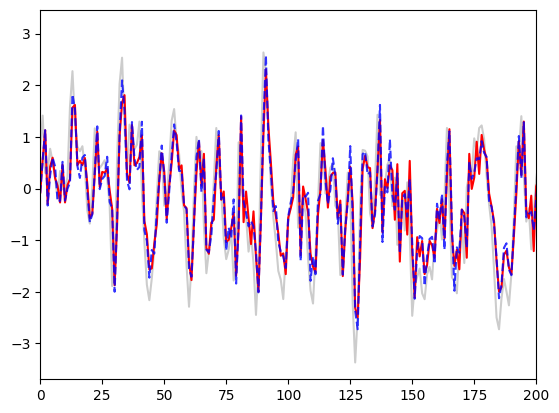

In [48]:
best_model_arma = ARIMA(y, order=(1,0,2))
best_fit_arma = best_model_arma.fit()

true_model_arma = ARIMA(y, order=order_true)
true_fit_arma = true_model_arma.fit()

sn.lineplot(y, c='k', alpha=0.2)
sn.lineplot(best_fit_arma.fittedvalues, c='r', alpha=1)
sn.lineplot(true_fit_arma.fittedvalues, linestyle='--', c='b', alpha=0.8)
plt.xlim(0,200)
plt.show()

Let us automatically find and fit the best model to part of the data and check the performance of the model, with a train and test portions of the time series:

In [49]:
aicc_list = []
order_list = []

y_train = y[:700]

for i in range(1,6):
    for j in range(1,6):
        order = (i,0,j)
        order_list.append(order)
        model_arma = ARIMA(y_train, order=order)
        fit_arma = model_arma.fit()
        aicc = fit_arma.aicc
        aicc_list.append(aicc)

idx = aicc_list.index(min(aicc_list))
optimal_order = order_list[idx]

print('Optimal order:', optimal_order)
print('Ground true:', order_true)

Optimal order: (1, 0, 3)
Ground true: (1, 0, 4)


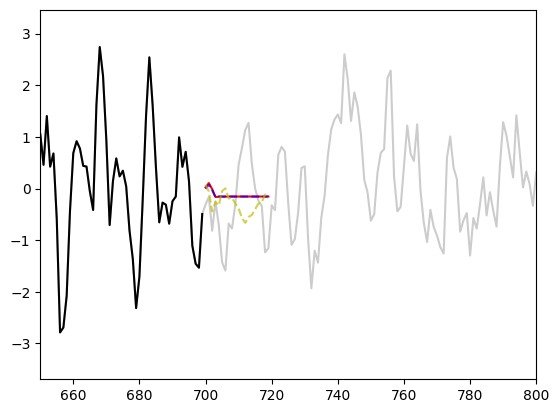

In [60]:
initial_step = 700
y_train = y[:initial_step]

best_model_arma = ARIMA(y_train, order=optimal_order)
best_fit_arma = best_model_arma.fit()

true_model_arma = ARIMA(y_train, order=order_true)
true_fit_arma = true_model_arma.fit()

#other random model with higher order
other_model_arma = ARIMA(y_train, order=(20,0,20))
other_fit_arma = other_model_arma.fit()

steps_test = 20
y_pred_best = best_fit_arma.forecast(steps_test)
y_pred_true = true_fit_arma.forecast(steps_test)
y_pred_other = other_fit_arma.forecast(steps_test)

X_test = np.arange(initial_step, initial_step + steps_test)

sn.lineplot(y, c='k', alpha=0.2)
sn.lineplot(y_train, c='k', alpha=1)
sn.lineplot(x=X_test, y=y_pred_true, c='r', alpha=1)
sn.lineplot(x=X_test, y=y_pred_best, linestyle='--', c='b', alpha=0.7)
sn.lineplot(x=X_test, y=y_pred_other, linestyle='--', c='y', alpha=0.7)
plt.xlim(initial_step-50,initial_step+100)
plt.show()

### Vector Autoregression

In [51]:
demand_data.head()

,"Week_of_the_month_(first_week,second,third,fourth_or_fifth_week)",Day_of_the_week_(Monday_to_Friday),Non-urgent_order,Urgent_order,Order_type_A,Order_type_B,Order_type_C,Fiscal_sector_orders,Orders_from_the_traffic_controller_sector,Banking_orders_(1),Banking_orders_(2),Banking_orders_(3),Target_(Total_orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


Determine the best `VAR` parameter:

In [52]:
var_data = demand_data.iloc[:, 11:13]

# Perform VAR model selection with AIC
best_aic = float('inf')
best_order_aic = None

# Iterate over different lag orders
for p in range(1, 5):  # Assuming maximum lag of 4
    # Fit VAR model for current lag order
    var_model = VAR(var_data)
    results = var_model.fit(p, trend='c')
    
    # Calculate AIC for the current model
    aic = results.aic
    
    # Update best AIC and lag order if current AIC is lower
    if aic < best_aic:
        best_aic = aic
        best_order_aic = p

print("Best lag order based on AIC:", best_order_aic)

Best lag order based on AIC: 2


In [53]:
var_best_model = VAR(var_data)
result_var = var_best_model.fit(maxlags=2, trend='c')

<Axes: title={'center': 'Target_(Total_orders)'}, ylabel='Target_(Total_orders)'>

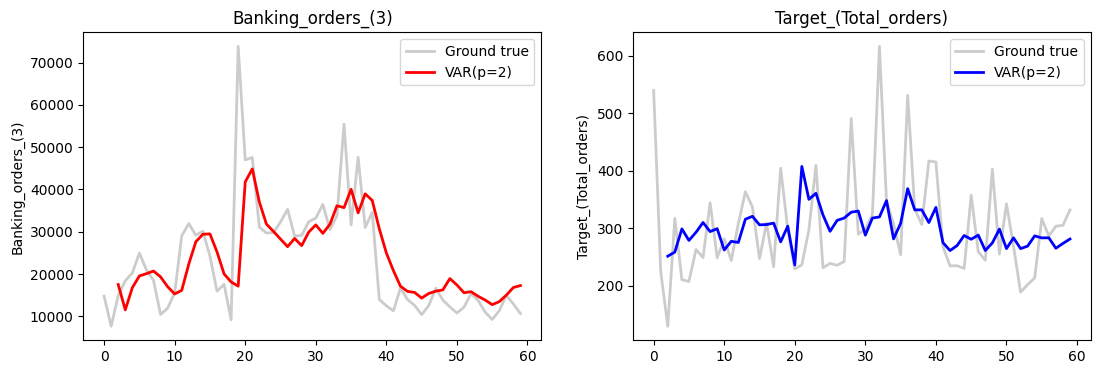

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

plt.subplot(121)
plt.title('Banking_orders_(3)')
sn.lineplot(demand_data['Banking_orders_(3)'], c='k', alpha=0.2, lw=2, label='Ground true')
sn.lineplot(result_var.fittedvalues.iloc[:,0], c='r', lw=2, linestyle='-', label='VAR(p=2)')

plt.subplot(122)
plt.title('Target_(Total_orders)')
sn.lineplot(demand_data['Target_(Total_orders)'], c='k', alpha=0.2, lw=2, label='Ground true')
sn.lineplot(result_var.fittedvalues.iloc[:,1], c='b', lw=2, linestyle='-', label='VAR(p=2)')

In [55]:
acorr_ljungbox(result_var.resid.iloc[:,0], lags=8)

,lb_stat,lb_pvalue
1,0.186070,0.666208
2,1.254221,0.534133
3,3.799023,0.284000
4,4.558191,0.335703
5,4.576535,0.469709
6,5.028290,0.540190
7,7.775393,0.352816
8,11.111962,0.195436


In [56]:
acorr_ljungbox(result_var.resid.iloc[:,1], lags=8)

,lb_stat,lb_pvalue
1,0.378315,0.538507
2,0.890063,0.640804
3,1.131175,0.769554
4,3.710643,0.446580
5,4.050604,0.542153
6,5.084403,0.533034
7,6.097556,0.528406
8,6.191674,0.625771
